In [1]:
#%matplotlib notebook
import time, winsound, h5py, os
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

In [2]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 9.5e3

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 42.4e-6,
    'sigma_y': 42.4e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 0
}

In [28]:
def define_branch1(E0=E0, d23 = 1, FOV = 1e-4, N = 1024):
    # crystal reflection hkl index
    hkl = [2,2,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=400-.1, FOV=2e-3, N=N)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=400, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    # second crystal: symmetric reflection, orientation flipped relative to crystal 1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,
                              alphaAsym=0, orientation=2, pol='s', delta=0.e-6)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im1 = optics.PPM('im1', z=crystal2.z + d23/2, FOV=2e-3, N=N)

    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=im1.z+d23/2, E0=E0,
                              alphaAsym=0, orientation=2, pol='s', asym_type='emergence')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+.2, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', asym_type='emergence')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=FOV, N=N)

    # list of devices to propagate through
    devices = [im0, crystal1, crystal2, im1, crystal3, crystal4, im2]

    return devices

def define_branch2(E0=E0, d23 = .2, alphaAsym=np.deg2rad(5), FOV = 10e-6, N = 1024):
    # crystal reflection hkl index
    hkl = [2,2,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=400-.1, FOV = 1e-4, N=N)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=400.4, E0=E0,
                              alphaAsym=0, orientation=2, pol='s', delta=0.e-6)

    # second crystal: symmetric reflection, orientation flipped relative to crystal 1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,
                              alphaAsym=alphaAsym, orientation=0, pol='s', delta=0.e-6)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im1 = optics.PPM('im1', z=crystal2.z + d23/2, FOV=2e-3, N=N)

    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=im1.z+d23/2, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', asym_type='emergence')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+.2, E0=E0,
                              alphaAsym=alphaAsym, orientation=2, pol='s', asym_type='emergence')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+crystal1.z-400+.1, FOV=FOV, N=N)

    # list of devices to propagate through
    devices = [im0, crystal1, crystal2, im1, crystal3, crystal4, im2]

    return devices

In [29]:
# initialize optical elements
devices_b1 = define_branch1(E0)
devices_b2 = define_branch2(E0)
branch1 = beamline.Beamline(devices_b1)
branch2 = beamline.Beamline(devices_b2)

for oe in devices_b1:
    if oe.name == 'c1':
        print('crystal 1 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('crystal 1 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))

for oe in devices_b2:
    if oe.name == 'c1':
        print('crystal 1 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('crystal 1 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))
        
# propagate
b1_1 = beam.Beam(beam_params=beam_params)
b1_2 = branch1.propagate_beamline(b1_1)

b2_1 = beam.Beam(beam_params=beam_params)
b2_2 = branch2.propagate_beamline(b2_1)

b 1.00
b 1.00
crystal 2 incidence angle: 19.87 degrees
crystal 2 exit angle: 19.87 degrees
b 1.00
b 1.00
b 1.00
b 1.64
crystal 2 incidence angle: 24.87 degrees
crystal 2 exit angle: 14.87 degrees
b 1.00
b 1.64
after c1: 0.6936
after c2: 0.0000
after c3: -0.6936
after c4: 0.0000
after c1: -0.6936
after c2: 0.0000
after c3: 0.6936
after c4: 0.0000
crystal 1 incidence angle: 19.87 degrees
crystal 1 exit angle: 19.87 degrees



crystal 1 incidence angle: 19.87 degrees
crystal 1 exit angle: 19.87 degrees



FWHM in x: 70.7559329526507 microns
FWHM in y: 70.7559329526507 microns
FWHM Divergence (x): 1.2 μrad
FWHM Divergence (y): 1.2 μrad
43.276695384983796
43.276695384983796
x is focused
y is focused
FWHM in x: 465.021978268688 microns
FWHM in y: 465.021978268688 microns
FWHM Divergence (x): 1.2 μrad
FWHM Divergence (y): 1.2 μrad
43.276695384983796
43.276695384983796
x is focused
y is focused
im0
zx: 399.900000
zy: 399.900000
azimuth 0.00 mrad
drift1
global_x 0.00
global_y 0.00
x intersect: 

C:\Users\nanw0\Anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


zx: 400.760087
zy: 400.760087
azimuth 0.00 mrad
im1
zx: 400.760087
zy: 400.760087
azimuth 0.00 mrad
drift4
global_x 0.17
global_y 0.00
x intersect: 1.6627e-01
component x: 1.6627e-01
y intersect: 0.0000e+00
component y: 0.0000e+00
delta z: 0.00
zRx: 254663982.55 microns
zRy: 254663982.55 microns
remaining distance: 500000.00 microns
goal for zx: 401260087.22 microns
current zx: 400760087.22 microns
goal for zy: 401260087.22 microns
current zy: 400760087.22 microns
zx: 401.260087
zy: 401.260087
azimuth 0.00 mrad
c3
[0. 0. 0.]
Calculated distance to focus: -401.260087
zRx: 2.55e+02
zRy: 2.55e+02
zx: 401.260087
zy: 401.260087
azimuth -693.56 mrad
drift5
global_x 0.17
global_y 0.00
x intersect: -4.7212e-14
component x: 0.0000e+00
y intersect: 0.0000e+00
component y: 0.0000e+00
delta z: 0.00
zRx: 254663982.55 microns
zRy: 254663982.55 microns
remaining distance: 260087.22 microns
goal for zx: 401520174.45 microns
current zx: 401260087.23 microns
goal for zy: 401520174.45 microns
current zy:

In [30]:
%%capture capt
tstart = time.time()
# propagate
beam_params['photonEnergy'] = E0
pulse_b1 = beam.Pulse(beam_params=beam_params, tau=400, time_window=10000)
pulse_b2 = beam.Pulse(beam_params=beam_params, tau=400, time_window=10000)
pulse_b1.propagate(beamline=branch1, screen_names=['im0','im1','im2'])
pulse_b2.propagate(beamline=branch2, screen_names=['im0','im1','im2'])
tfin = time.time()

(<matplotlib.axes._subplots.AxesSubplot at 0x22344d16608>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22344ca5688>)

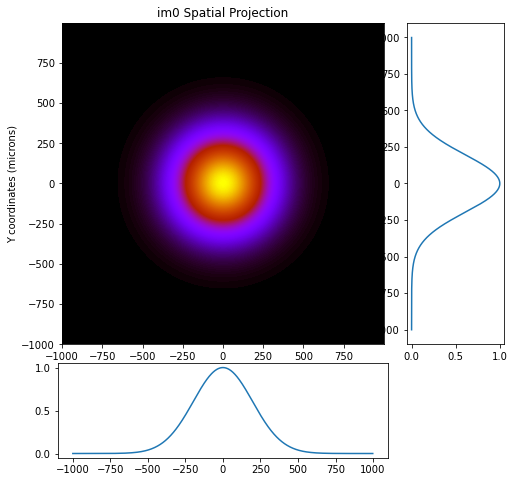

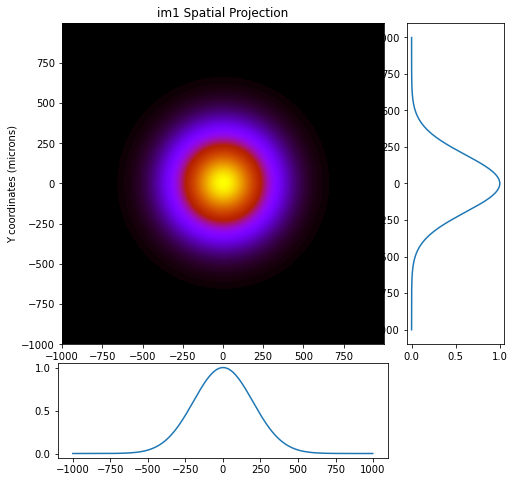

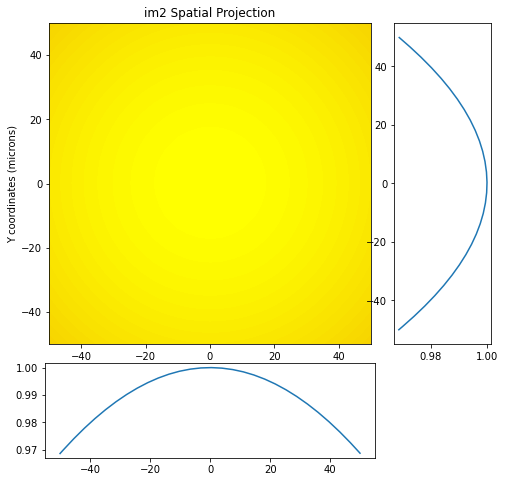

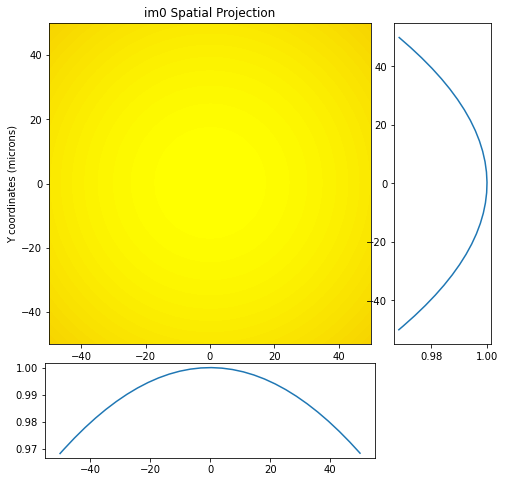

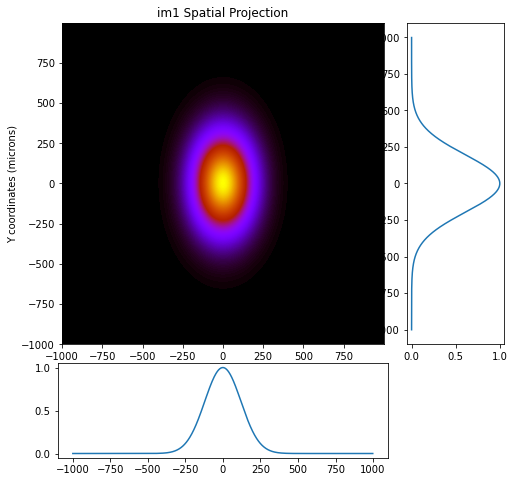

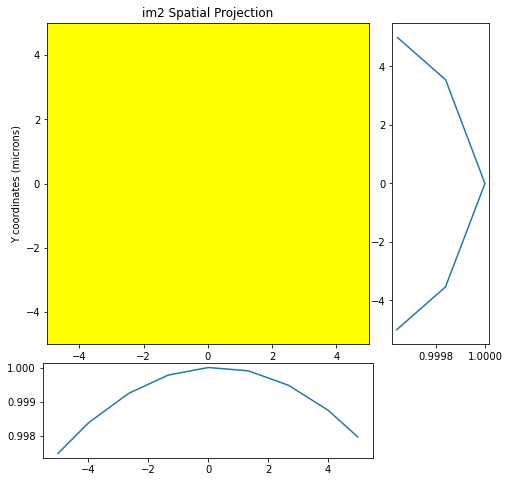

In [31]:
''' spatial projection (x,y)'''
pulse_b1.imshow_projection('im0')
pulse_b1.imshow_projection('im1')
pulse_b1.imshow_projection('im2')

pulse_b2.imshow_projection('im0')
pulse_b2.imshow_projection('im1')
pulse_b2.imshow_projection('im2')

In [ ]:
pulse_sum = pulse_b1.add_pulse(pulse_b2,0)
pulse_sum.imshow_projection('im0')
pulse_sum.imshow_projection('im1')
pulse_sum.imshow_projection('im2')